In [1]:
import sys

In [2]:
import pathlib
import xarray as xr

In [3]:
from init import *

In [4]:
import syfop

In [5]:
from syfop.util import *
from syfop.node import *
from syfop.network import *

In [6]:
import os
os.environ['GRB_LICENSE_FILE'] = '/home/pregner/gurobi.lic'

# this does not work in jupyter notebook, needs to be set in kernel spec!
# see /home/pregner/micromamba/envs/syfop-global-costs/share/jupyter/kernels/python3/kernel.json
# os.environ['LD_LIBRARY_PATH'] = '/opt/gurobi1001/linux64/lib'

## Parameters

In [7]:
battery_cost = 33             # EUR/KWh/a
hydrogen_storage_cost = 74    # EUR/kg/a
co2_storage_cost = 0.049      # EUR/kg/a

electrolizer_cost = 30        # kW/a
pv_cost = 53                  # EUR/kW/a
wind_cost = 128               # EUR/kW/a

electrolizer_efficiency_multiplier = 1
# electrolizer_efficiency = 0.63 * electrolizer_efficiency_multiplier
# 0.63 is the value for energy -> energy, if h2 is measured in tons, we use 0.019 according to Jo:
#     der wert von 0.019 entspricht einer effizienz von 0.63
#     wenn wir 0.69 rechnen wollen, multiplizieren wir 0.019 mit 069/0.63
#     1 KWh electricty * 0.019 = 1 kg H2
#
# 1kg_h2 = 33kWh, zur Herstellung: 1kg_h2 = 33/0.63kWh = 1/0.019 kWh
# --> 1 kWh = 0.019kg_h2
electrolizer_convert_factor = 0.019 * 1e-3  # 1KWh --> 1 ton h2

# -- below here probably constant for all scenarios

methanol_synthesis_cost = 42.  # in EUR/KW/a - taken from result csv


balanceCO2H2 = 7.268519  # from gams file
# balanceCO2H2 * h2 = co2
# --> balanceCO2H2 * h2 + h2 = co2 + h2
# --> (balanceCO2H2 + 1) * h2 = co2 + h2
# --> h2 / (co2 + h2) = 1/(balanceCO2H2 + 1)
methanol_synthesis_input_proportions = {"co2": 1 - 1/(balanceCO2H2 + 1), "electrolizer": 1/(balanceCO2H2 + 1)}

methanolSysnthesisEff = 5.093 * 5.54 * 1e3
methanol_synthesis_convert_factor = 1/(balanceCO2H2 + 1) * methanolSysnthesisEff

storage_params = {
    'electricity':{
        'costs': battery_cost,
        'max_charging_speed': 0.4,   # taken from GAMS file (value from Jo)
        'storage_loss': 0.01,        # 0.99 from GAMS file
        'charging_loss': 0.1,        # 0.9 in gdx and result file
    },
    'co2': {
        'costs': 1e3 * co2_storage_cost,
        'max_charging_speed': 0.2,   # taken from GAMS file (value from Jo)
        'storage_loss': 0,
        'charging_loss': 0,
    },
    'hydrogen': {
        'costs': 1e3 * hydrogen_storage_cost,
        'max_charging_speed': 0.2,   # taken from GAMS file (value from Jo)
        'storage_loss': 0,
        'charging_loss': 0,
    },
}

In [8]:
co2_capture_cost = 1

## Renewable time series

In [9]:
# XXX whats the unit here?!

In [10]:
wind_raw = xr.open_mfdataset([INTERIM_DIR / 'wind' / f'wind_2012-{month:02d}.nc' for month in MONTHS])
pv_raw = xr.open_mfdataset([INTERIM_DIR / 'wind' / f'wind_2012-{month:02d}.nc' for month in MONTHS])

In [11]:
x_idx = 132
y_idx = 233

In [12]:
# oh no! we picked a leap year by chance... let's just throw away the last day
wind = wind_raw.isel(x=x_idx, y=y_idx, time=slice(None, 8760))['specific generation'].load()
pv = pv_raw.isel(x=x_idx, y=y_idx, time=slice(None, 8760))['specific generation'].load()

## Model

In [13]:
methanol_demand_timeseries = const_time_series(0., time_coords=pv.time)
methanol_demand_timeseries[-1] = 1000

In [14]:
# note: for now we don't distinguish between KW and KWh (per time stamp), this is okayish since we have hourly time stamps

solar_pv = NodeScalableInputProfile(
    name="solar_pv",
    input_flow=pv,
    costs=pv_cost,
    output_unit="KW",
)
wind_class2 = NodeScalableInputProfile(
    name="wind_class2",
    input_flow=wind,
    costs=wind_cost,
    output_unit="KW",
)
#wind_class3 = NodeScalableInputProfile(
#    name="wind_class3",
#    input_flow=wind(),
#    costs=wind_cost,
#    output_unit="KW",
#)
electricity = Node(
    name="electricity",
    inputs=[solar_pv, wind_class2],
    input_commodities="electricity",
    costs=0,
    storage=Storage(**storage_params['electricity']),
    output_unit="KW",
)
curtail_electricity = Node(
    name="curtail_electricity",
    inputs=[electricity],
    input_commodities="electricity",
    costs=0,
    output_unit="KW",
)
electrolizer = Node(
    name="electrolizer",
    inputs=[electricity],
    input_commodities="electricity",
    costs=1/electrolizer_convert_factor * electrolizer_cost,
    convert_factor=electrolizer_convert_factor,
    output_unit="t",
    storage=Storage(**storage_params['hydrogen']),
)
co2 = Node(
    name="co2",
    inputs=[],
    input_commodities="co2",
    costs=co2_capture_cost,
    convert_factor=electrolizer_convert_factor,
    output_unit="t",
    storage=Storage(**storage_params['hydrogen']),
)

methanol_synthesis = Node(
    name="methanol_synthesis",
    inputs=[co2, electrolizer],
    input_commodities=["co2", "hydrogen"],
    costs=methanol_synthesis_cost,
    convert_factor=methanol_synthesis_convert_factor,
    output_unit="KW",
    input_proportions=methanol_synthesis_input_proportions,
    storage=Storage(**{
        'costs': 0.,   # we just set a minimum methanol production per year but do not care when
                       # this is modelled via a free storage
        'max_charging_speed': 1,
        'storage_loss': 0,
        'charging_loss': 0,
    }),
)

methanol_demand = NodeFixOutputProfile(
    name="methanol_demand",
    inputs=[methanol_synthesis],
    input_commodities=['methanol'],
    output_flow=methanol_demand_timeseries,
    costs=0,  # XXX why does this cost something if it is fixed and not scalable?
    output_unit='KW',
)

network = Network(
    [
        solar_pv,
        wind_class2,
        #wind_class3,
        electricity,
        curtail_electricity,
        electrolizer,
        co2,
        methanol_synthesis,
        methanol_demand,
    ],
    time_coords=pv.time
)

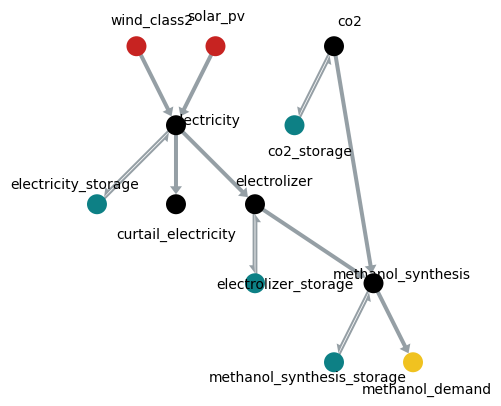

In [15]:
network.draw()

In [16]:
# network.optimize('highs')
network.optimize('gurobi')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-02
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: AMD Ryzen Threadripper 2950X 16-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 254040 rows, 183969 columns and 689954 nonzeros
Model fingerprint: 0x11b17282
Coefficient statistics:
  Matrix range     [2e-05, 3e+03]
  Objective range  [1e+00, 2e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 97615 rows and 88856 columns
Presolve time: 0.77s
Presolved: 156425 rows, 95113 columns, 433866 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 7
 AA' NZ     : 4.999e+05
 Factor NZ  : 2.406e+06 (roughly 120 MB of memory)
 Factor Ops : 4.079e+07 (less than 1 second per iteration)
 Thread

In [17]:
network.model.solution.size_storage_co2

<xarray.DataArray 'size_storage_co2' ()>
array(0.)

## With electricity for air capture

In [18]:
# note: for now we don't distinguish between KW and KWh (per time stamp), this is okayish since we have hourly time stamps

solar_pv = NodeScalableInputProfile(
    name="solar_pv",
    input_flow=pv,
    costs=pv_cost,
    output_unit="KW",
)
wind_class2 = NodeScalableInputProfile(
    name="wind_class2",
    input_flow=wind,
    costs=wind_cost,
    output_unit="KW",
)
#wind_class3 = NodeScalableInputProfile(
#    name="wind_class3",
#    input_flow=wind(),
#    costs=wind_cost,
#    output_unit="KW",
#)
electricity = Node(
    name="electricity",
    inputs=[solar_pv, wind_class2],
    input_commodities="electricity",
    costs=0,
    storage=Storage(**storage_params['electricity']),
    output_unit="KW",
)
curtail_electricity = Node(
    name="curtail_electricity",
    inputs=[electricity],
    input_commodities="electricity",
    costs=0,
    output_unit="KW",
)
electrolizer = Node(
    name="electrolizer",
    inputs=[electricity],
    input_commodities="electricity",
    costs=1/electrolizer_convert_factor * electrolizer_cost,
    convert_factor=electrolizer_convert_factor,
    output_unit="t",
    storage=Storage(**storage_params['hydrogen']),
)
co2 = Node(
    name="co2",
    inputs=[electricity],
    input_commodities="electricity",
    costs=co2_capture_cost,
    convert_factor=electrolizer_convert_factor,
    output_unit="t",
    storage=Storage(**storage_params['hydrogen']),
)

methanol_synthesis = Node(
    name="methanol_synthesis",
    inputs=[co2, electrolizer],
    input_commodities=["co2", "hydrogen"],
    costs=methanol_synthesis_cost,
    convert_factor=methanol_synthesis_convert_factor,
    output_unit="KW",
    input_proportions=methanol_synthesis_input_proportions,
    storage=Storage(**{
        'costs': 0.,   # we just set a minimum methanol production per year but do not care when
                       # this is modelled via a free storage
        'max_charging_speed': 1,
        'storage_loss': 0,
        'charging_loss': 0,
    }),
)

methanol_demand = NodeFixOutputProfile(
    name="methanol_demand",
    inputs=[methanol_synthesis],
    input_commodities=['methanol'],
    output_flow=methanol_demand_timeseries,
    costs=0,  # XXX why does this cost something if it is fixed and not scalable?
    output_unit='KW',
)

network = Network(
    [
        solar_pv,
        wind_class2,
        #wind_class3,
        electricity,
        curtail_electricity,
        electrolizer,
        co2,
        methanol_synthesis,
        methanol_demand,
    ],
    time_coords=pv.time
)

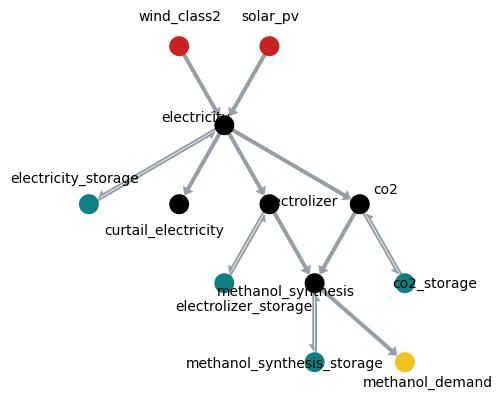

In [19]:
network.draw()

In [20]:
# network.optimize('highs')
network.optimize('gurobi')

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: AMD Ryzen Threadripper 2950X 16-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 254040 rows, 183969 columns and 698714 nonzeros
Model fingerprint: 0xba40343a
Coefficient statistics:
  Matrix range     [2e-05, 3e+03]
  Objective range  [1e+00, 2e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 97616 rows and 80097 columns
Presolve time: 0.39s
Presolved: 156424 rows, 103872 columns, 451384 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 7
 AA' NZ     : 5.087e+05
 Factor NZ  : 2.358e+06 (roughly 120 MB of memory)
 Factor Ops : 3.949e+07 (less than 1 second per iteration)
 Threads    : 14

                  Objective                Residual
Iter       Primal          

In [21]:
network.model.solution

<xarray.Dataset>
Dimensions:                                  (time: 8760)
Coordinates:
  * time                                     (time) datetime64[ns] 2012-01-01...
Data variables: (12/30)
    size_solar_pv                            float64 4.6
    size_wind_class2                         float64 0.0
    flow_solar_pv_electricity                (time) float64 2.11 ... 0.8643
    flow_wind_class2_electricity             (time) float64 0.0 0.0 ... 0.0 0.0
    size_storage_electricity                 float64 0.0
    storage_level_electricity                (time) float64 0.0 0.0 ... 0.0 0.0
    ...                                       ...
    storage_level_methanol_synthesis         (time) float64 0.1368 ... 0.0
    storage_charge_methanol_synthesis        (time) float64 0.1368 0.112 ... 0.0
    storage_discharge_methanol_synthesis     (time) float64 0.0 0.0 ... 999.9
    size_methanol_synthesis                  float64 1e+03
    flow_methanol_synthesis_methanol_demand  (time) float64 0.0 0.0 ... 1e+03
    output_flow_curtail_electricity          (time) float64 0.0 0.0 ... 0.0 0.0